In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
from tqdm import tqdm

def extract_features_from_loader(dataloader, device='mps'):
    model = models.resnet18(pretrained=True)
    model = nn.Sequential(*list(model.children())[:-1])  # Remove classification layer
    model.to(device)
    model.eval()

    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Extracting features"):
            images = images.to(device)
            feats = model(images).squeeze(-1).squeeze(-1)  # (B, 2048)
            all_features.append(feats.cpu())
            all_labels.append(labels)

    features = torch.cat(all_features, dim=0).numpy()
    labels = torch.cat(all_labels, dim=0).numpy()
    return features, labels


In [2]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_clusters(features_2d, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', s=10)
    plt.title(title)
    plt.show()

def apply_and_plot_clustering(features, true_labels=None):
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)

    # KMeans
    kmeans = KMeans(n_clusters=4, random_state=42)
    kmeans_labels = kmeans.fit_predict(features)
    plot_clusters(features_2d, kmeans_labels, "KMeans Clustering")

    # DBSCAN
    dbscan = DBSCAN(eps=5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(features)
    plot_clusters(features_2d, dbscan_labels, "DBSCAN Clustering")

    # Agglomerative
    agglo = AgglomerativeClustering(n_clusters=4)
    agglo_labels = agglo.fit_predict(features)
    plot_clusters(features_2d, agglo_labels, "Agglomerative Clustering")

    # Spectral
    spectral = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', n_neighbors=89, random_state=42)
    spectral_labels = spectral.fit_predict(features)
    plot_clusters(features_2d, spectral_labels, "KNN Clustering")


/opt/anaconda3/envs/algo_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/algo_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting features: 100%|██████████| 250/250 [04:30<00:00,  1.08s/it]


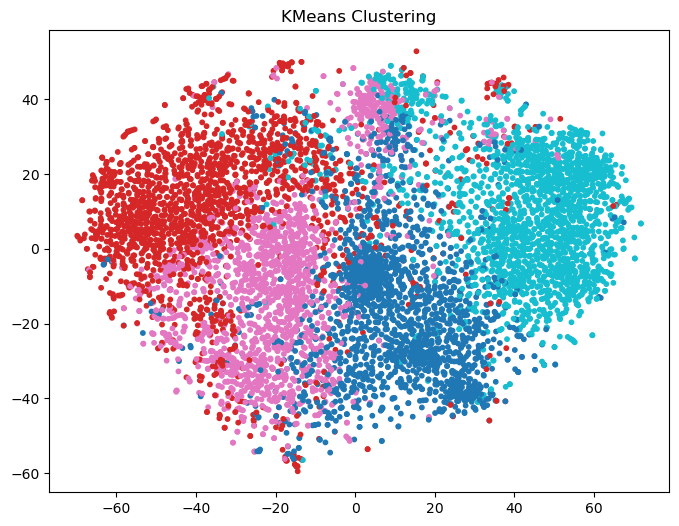

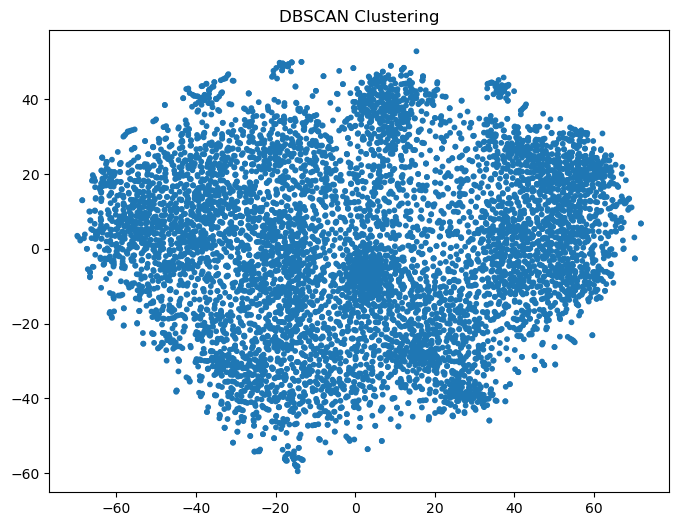

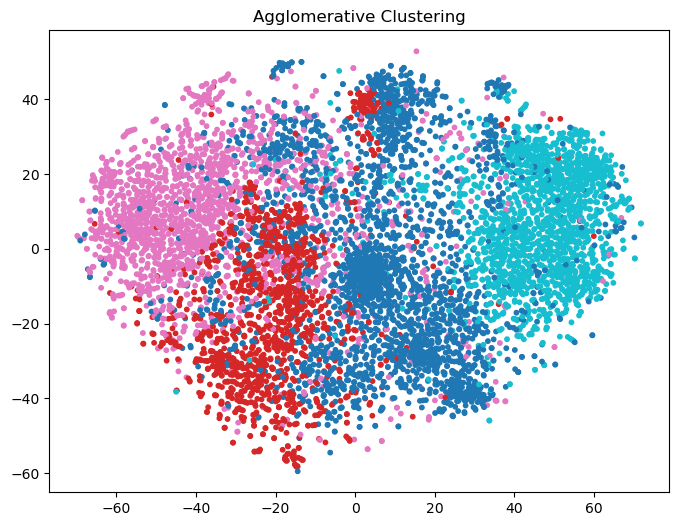

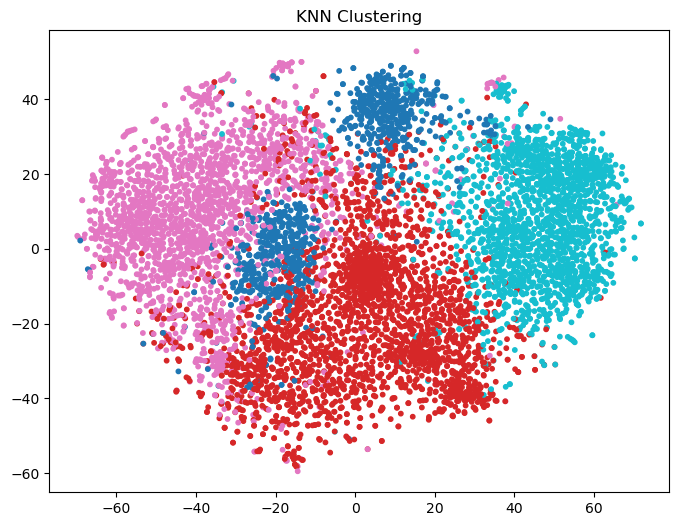

In [4]:
from art_clustering.data_loaders.again import WikiSubsetLoaderAgain

root_dir='/Volumes/T7/university/sem2/wikiart/smol_data'

loader = WikiSubsetLoaderAgain(root_dir=root_dir, batch_size=32, normalize=True)
dataloader = loader.get_loader()

features, labels = extract_features_from_loader(dataloader, device='mps')
apply_and_plot_clustering(features, true_labels=labels)

In [5]:
# Save features and labels to disk
import numpy as np
np.save('features_samenum.npy', features)
np.save('labels_samenum.npy', labels)